# Введение в PyTorch

**На этом уроке мы рассмотрим как при помощи PyTorch:**
- Работать с данными
- Создавать свои модели нейросетей (на примере полносвязных и сверточных сетей)
- Обучать созданные модели
- Сохранять и загружать обученные модели (checkpoints)
- Делать предсказания (инференс)
- Ускорить инференс при помощи компиляции моделей (PyTorch 2.0)
- Transfer Lerning из одного датасета в другой

В качестве датасетов будем использовать MNIST и CIFAR10.

**Для начала импортируем необходимые библиотеки:**

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.__version__

'2.6.0+cu124'

In [2]:
# Вспомогательная функция для визуализации данных:
def show(img, title=''):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
    plt.show()

## 1 Работа с данными

In [3]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

**Загрузка датасета**

In [4]:
# Скачиваем данные для обучения:
training_data = datasets.MNIST(
    root="./dataset",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Скачиваем данные для теста:
test_data = datasets.MNIST(
    root="./dataset",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.83MB/s]


**Визуализация данных**

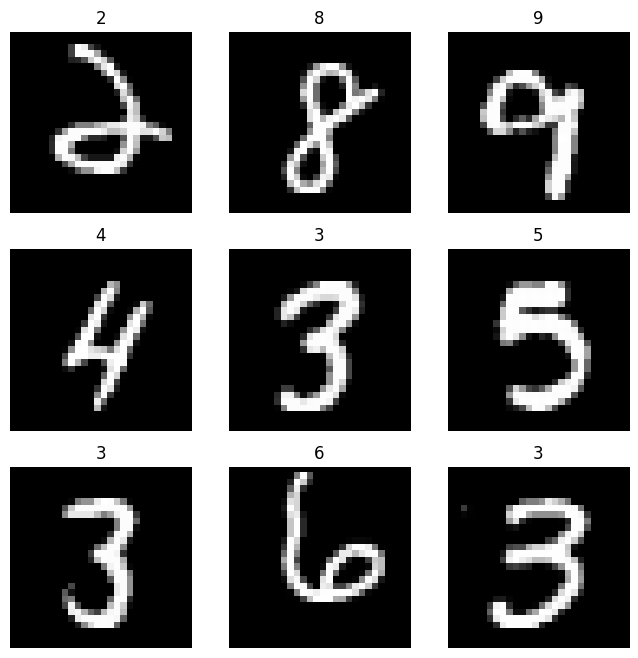

In [5]:
# Визуализируем рандомные сэмплы из MNIST:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # squeeze() - удаляем все измерения размером 1
plt.show();


figure: (torch.Size([1, 28, 28]), <class 'torch.Tensor'>)


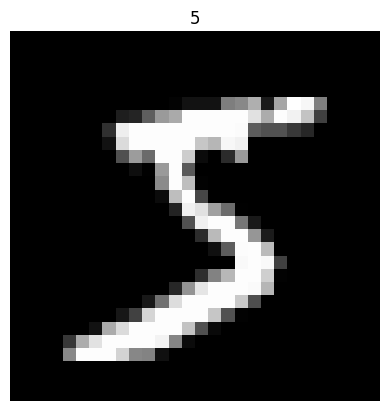

In [6]:
img, label = training_data[0]
print(f'figure: {img.shape, type(img)}')

plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray") # squeeze() - удаляем все измерения размером 1

plt.show()

**Итерирование через данные**

In [7]:
batch_size = 64 # крупные батчи требуют больше оперативной памяти

# Создаем data loaders:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape o

## 2 Создание модели

#### Слои
[**Flatten**](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) -  трансформирует 2D изображение (28x28 пикселей) в вектор (784 пикселей).

[**Linear**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) -  применяет линейную трансформацию к входным данным используя веса модели и смещение (bias)


[**ReLU**](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) -  функция активации, добавляет нейлинейность в модель, что позволяет модели аппроксимировать нейлинейные функции


[**Sequential**](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) -  упорядоченный контейнер модулей нейронной сети, предназначенный для быстрого создания сетей с последовательной архитектурой. Данные будут проходить слои модели в том порядке, в котором они описаны.

[**Softmax**](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) -  это обобщение логистической функции на несколько измерений, используется для нормализации выходных данных сети (в диапазон значений [0,1], которые в сумме дают 1):

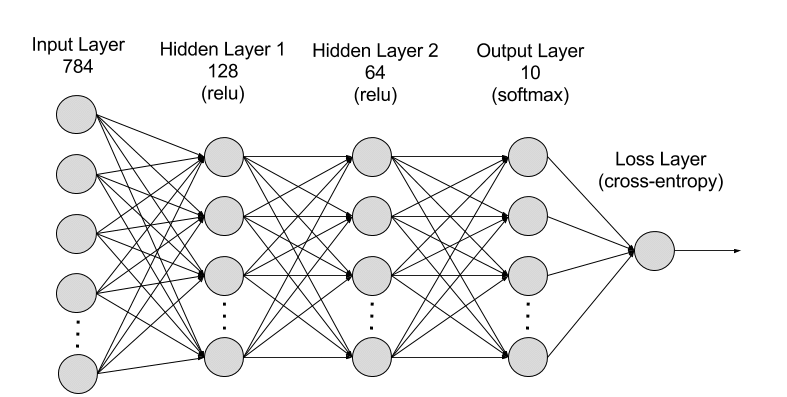

In [8]:
# Выбираем девайс (cpu или gpu), на котором будут происходит вычисления:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Определяем кастомную модель (на конструкторе Sequential):
class NeuralNetworkSeq(nn.Module):
    def __init__(self, input_size=(28,28,1), output_size=10):
        super(NeuralNetworkSeq, self).__init__()
        self.flatten = nn.Flatten()
        self.output = nn.Linear(512, output_size)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size[0]*input_size[1]*input_size[2], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            self.output
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model_seq = NeuralNetworkSeq().to(device)
print(model_seq)

Using cuda device
NeuralNetworkSeq(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
# Определяем кастомную модель (на стандартном модуле):
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=(28,28,1), output_size=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size[0]*input_size[1]*input_size[2], 512)
        self.fc2 = nn.Linear(512, 512)
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        logits = self.output(x)

        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU(inplace=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)


In [10]:
# Мы можем итерироваться через параметры (веса) нашей модели:
for name, param in model.named_parameters():
    print(f"Имя: {name} | Размер: {param.size()} | Значения : {param[:2]} \n")

Имя: fc1.weight | Размер: torch.Size([512, 784]) | Значения : tensor([[ 0.0146,  0.0042,  0.0006,  ...,  0.0204,  0.0258, -0.0356],
        [-0.0033, -0.0048,  0.0218,  ..., -0.0324, -0.0020, -0.0097]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Имя: fc1.bias | Размер: torch.Size([512]) | Значения : tensor([ 0.0019, -0.0197], device='cuda:0', grad_fn=<SliceBackward0>) 

Имя: fc2.weight | Размер: torch.Size([512, 512]) | Значения : tensor([[ 0.0266, -0.0044,  0.0124,  ..., -0.0205, -0.0123, -0.0196],
        [ 0.0270, -0.0153, -0.0261,  ..., -0.0001,  0.0231,  0.0010]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Имя: fc2.bias | Размер: torch.Size([512]) | Значения : tensor([-0.0298, -0.0212], device='cuda:0', grad_fn=<SliceBackward0>) 

Имя: output.weight | Размер: torch.Size([10, 512]) | Значения : tensor([[ 0.0081,  0.0052,  0.0379,  ..., -0.0131,  0.0365, -0.0394],
        [-0.0406, -0.0296, -0.0278,  ..., -0.0090,  0.0041,  0.0121]],
       device='cuda:0', grad_fn

Протестируем соответствие размерности данных структуре нашей модели

Ненормализованные вероятности:
 tensor([[ 0.0708,  0.0201,  0.0017,  0.0522, -0.0097, -0.0281, -0.0674,  0.0008,
         -0.0146,  0.0077]])
Нормализованные вероятности:
 tensor([[0.1069, 0.1016, 0.0998, 0.1049, 0.0986, 0.0968, 0.0931, 0.0997, 0.0982,
         0.1004]])


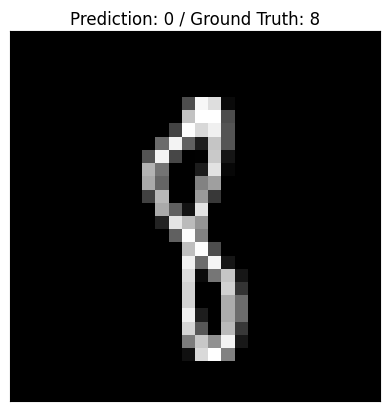

In [11]:
# Пропустим рандомное изображение из MNIST через нашу еще необученную модель:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
X, Y = training_data[sample_idx]
X = X.to(device)

# Forward pass:
logits = model(X)
pred_prob = nn.Softmax(dim=1)(logits)
Y_pred = pred_prob.argmax(1)

print('Ненормализованные вероятности:\n', logits.cpu().detach())
print('Нормализованные вероятности:\n', pred_prob.cpu().detach())
text = f"Prediction: {Y_pred.item()} / Ground Truth: {Y}"
show(X.cpu().squeeze(), title=text)

## 3 Обучение (оптимизация параметров модели)

In [12]:
# Функция для обучения модели:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Делаем предсказания:
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# Функция для тестирования обученной модели:
def test(dataloader, model, loss_fn, verbose=True, iterations=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if iterations is not None and i >= iterations:
                break

    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Функции потерь / Loss Functions

[**MSELoss**](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) -  Mean Square Error / Squared L2 (среднеквадратичная ошибка / квадратичная L2 норма.


[**CrossEntropyLoss**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) -  Перекрестная энтропия, комбинирует Softmax и Negative Log Likelihood.

### Оптимайзеры / Optimizers
[**SGD**](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html?highlight=sgd#torch.optim.SGD) -  Стохастический градиентный спуск, принимает аргументы:
- параметры модели,
- learning rate (скорость обучения),
- momentum (импульс),
- weight_decay (распад весов, помогает регуляризировать модель, тем самым предотвращая переобучения).

[**Adam**](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam) -  Оптимизационный алгоритм Адама:
- параметры модели,
- learning rate (скорость обучения),
- betas,
- weight_decay.

In [13]:
# Инициализируем модель и data loaders:
model = NeuralNetwork().to(device)
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Задаем гипперпараметры:
epochs = 3
batch_size = 64
lr = 1e-3

# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох (эпоха - один проход по всем данным):
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303646  [    0/60000]
loss: 0.288992  [ 6400/60000]
loss: 0.214995  [12800/60000]
loss: 0.245172  [19200/60000]
loss: 0.140715  [25600/60000]
loss: 0.364107  [32000/60000]
loss: 0.140320  [38400/60000]
loss: 0.232084  [44800/60000]
loss: 0.304270  [51200/60000]
loss: 0.162104  [57600/60000]
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.158160 

Epoch 2
-------------------------------
loss: 0.108942  [    0/60000]
loss: 0.083695  [ 6400/60000]
loss: 0.097835  [12800/60000]
loss: 0.120143  [19200/60000]
loss: 0.032261  [25600/60000]
loss: 0.163361  [32000/60000]
loss: 0.060617  [38400/60000]
loss: 0.126047  [44800/60000]
loss: 0.121058  [51200/60000]
loss: 0.113325  [57600/60000]
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.101788 

Epoch 3
-------------------------------
loss: 0.067891  [    0/60000]
loss: 0.023567  [ 6400/60000]
loss: 0.065037  [12800/60000]
loss: 0.096382  [19200/60000]
loss: 0.059296  [25600/60000]
loss: 0.068220  [32000/600

## 4 Сохранение и загрузка обученной модели

In [14]:
!mkdir checkpoints

# Сохраняем checkpoint (только веса):
checkpoint_path = './checkpoints/mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)
print("Saved PyTorch Model State to {}".format(checkpoint_path))

Saved PyTorch Model State to ./checkpoints/mnist_checkpoint.pth


In [15]:
# Создаем модель (объект класса NeuralNetwork) и загружаем параметры из checkpoint:
model = NeuralNetwork()
model.load_state_dict(torch.load(checkpoint_path))
# print (model.state_dict())

<All keys matched successfully>

In [16]:
# Протестируем загруженную модель (чтобы убедиться что все правильно загрузилось):
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.091091 



## 5 Делаем предсказания (inference)

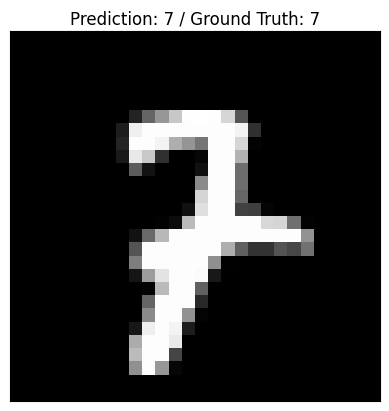

In [17]:
# Опишем название классов:
classes = ['0','1','2','3','4','5','6','7','8','9']

sample_idx = torch.randint(len(test_data), size=(1,)).item()
x, y = test_data[sample_idx][0], test_data[sample_idx][1]
x = x.to(device)

model.eval()
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    text = f"Prediction: {predicted} / Ground Truth: {actual}"
    show(x.cpu().squeeze(), title=text)

## 6 Обучаем сверточную сеть

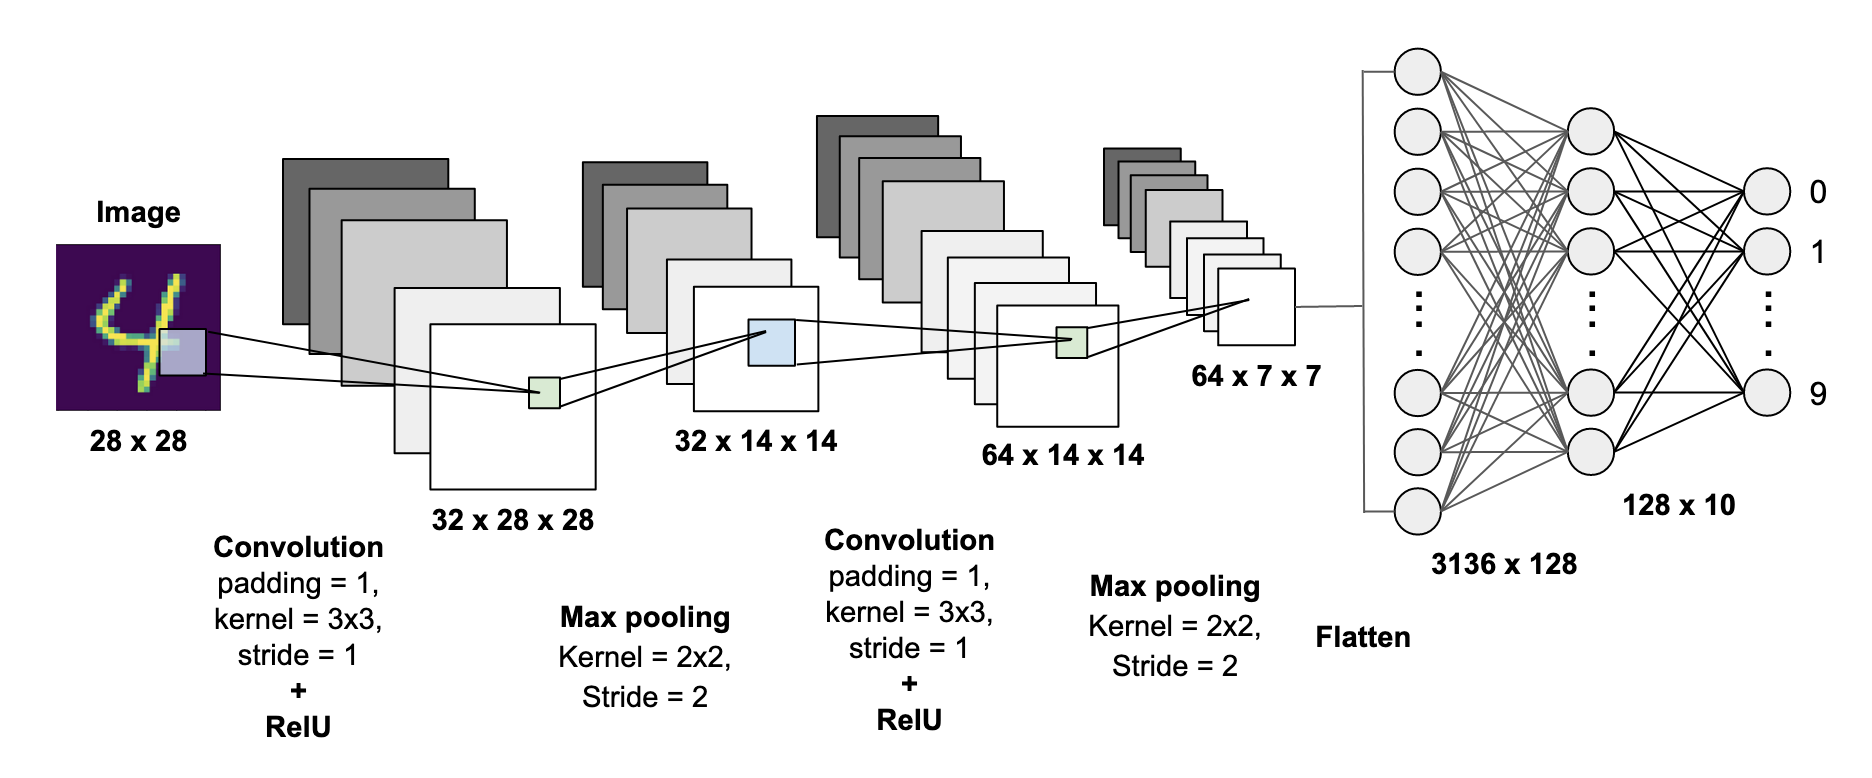

In [18]:
import torch.nn.functional as F     # импортируем функци активации

class CNN(nn.Module):
    def __init__(self, out_size, use_bn=True):
        super(CNN, self).__init__()
        # Стек слоев, которые мы можем в дальнейшем испоользовать:
        self.conv1 = nn.Conv2d(1, 32, 3, 1)     # 1: in channels, 32: out channels, 3: kernel size, 1: stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)         # 9216: in channels, 128: out channels
        self.fc2 = nn.Linear(128, out_size)
        self.use_bn = use_bn
        if use_bn:
            self.bn1 = nn.BatchNorm2d(32)
            self.bn2 = nn.BatchNorm2d(64)

    # Forward propagation:
    def forward(self, x):
        '''
        x reprenets our input data
        '''
        # Pass data through conv's layers:
        x = self.conv1(x)
        if self.use_bn:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x)
        x = F.relu(x)

        # Run max pooling over x:
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)

        # Pass data through FC's layers:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

cnn_model = CNN(10).to(device)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [19]:
# Инициализируем модель и data loaders:
cnn_model = CNN(10).to(device)
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Задаем гипперпараметры:
epochs = 1
batch_size = 64
lr = 1e-3

# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, cnn_model, loss_fn, optimizer)
    test(test_dataloader, cnn_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.408004  [    0/60000]
loss: 0.411026  [ 6400/60000]
loss: 0.115114  [12800/60000]
loss: 0.223472  [19200/60000]
loss: 0.195760  [25600/60000]
loss: 0.149191  [32000/60000]
loss: 0.124393  [38400/60000]
loss: 0.253233  [44800/60000]
loss: 0.423943  [51200/60000]
loss: 0.140381  [57600/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.059379 

Done!


In [20]:
# Протестируем обученную модель:
cnn_model = cnn_model.to(device)
loss_fn = nn.CrossEntropyLoss()
test(test_dataloader, cnn_model, loss_fn)

Test Error: 
 Accuracy: 98.2%, Avg loss: 0.059379 



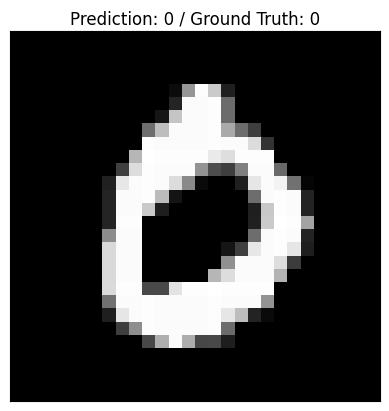

In [21]:
# Опишем название классов:
classes = ['0','1','2','3','4','5','6','7','8','9']

# Делаем предсказание:
sample_idx = 3
x, y = test_data[sample_idx][0], test_data[sample_idx][1]
x = x.to(device)

cnn_model.eval()
with torch.no_grad():
    pred = cnn_model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    text = f"Prediction: {predicted} / Ground Truth: {actual}"
    show(x.cpu().squeeze(), title=text)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Ускорерние инференеса в PyTorch 2.0

`torch.compile(model=None, *, fullgraph=False, dynamic=False, backend='inductor', mode=None, options=None, disable=False)`

Optimizes given model/function using TorchDynamo and specified backend.

Parameters:
- model (Callable) – Module/function to optimize
- fullgraph (bool) – Whether it is ok to break model into several subgraphs
- dynamic (bool) – Use dynamic shape tracing
- backend (str or Callable) – backend to be used
- mode (str) – Can be either “default”, “reduce-overhead” or “max-autotune”
- options (dict) – A dictionary of options to pass to the backend.
- disable (bool) – Turn torch.compile() into a no-op for testing

## Компиляция кастомной модели

In [22]:
import time

# Модель и лосс функция:
cnn_model = cnn_model.to(device)
loss_fn = nn.CrossEntropyLoss()


# Замерим время инференса модели без компиляции:
start = time.time()
for i in range(5):
    test(test_dataloader, cnn_model, loss_fn, verbose=False)
print(f'W/O compile: {time.time() - start}\n')


# Warm-up для компиляции:
torch._dynamo.reset()
compiled_cnn_model_ro = torch.compile(cnn_model)
test(test_dataloader, compiled_cnn_model_ro, loss_fn, verbose=False)

# Компилируем с defualt параметрами:
# - быстрое время компиляции
# - не использует дополнительную память для компиляции
compiled_cnn_model = torch.compile(cnn_model)
start = time.time()
for i in range(5):
    test(test_dataloader, compiled_cnn_model, loss_fn, verbose=False)
print(f'default: {time.time() - start}\n')


# Warm-up для компиляции:
torch._dynamo.reset()
compiled_cnn_model_ro = torch.compile(cnn_model, mode="reduce-overhead")
test(test_dataloader, compiled_cnn_model_ro, loss_fn, verbose=False)

# Компиляция reduce-overhead:
# - хорошо ускоряет небольшие модели
# - снижает накладные расходы фреймворка
# - использует дополнительную память для компиляци
compiled_cnn_model_ro = torch.compile(cnn_model, mode="reduce-overhead")
start = time.time()
for i in range(5):
    test(test_dataloader, compiled_cnn_model_ro, loss_fn, verbose=False)
print(f'reduce-overhead: {time.time() - start}\n')


# Warm-up для компиляции:
torch._dynamo.reset()
compiled_cnn_model_ro = torch.compile(cnn_model, mode="max-autotune")
test(test_dataloader, compiled_cnn_model_ro, loss_fn, verbose=False)

# Компиляция max-autotune:
# - выдает максимально быстрый код,
# - занимает значительное время для компиляции
compiled_cnn_model_ma = torch.compile(cnn_model, mode="max-autotune")
start = time.time()
for i in range(5):
    test(test_dataloader, compiled_cnn_model_ma, loss_fn, verbose=False)
print(f'max-autotune: {time.time() - start}\n')

W/O compile: 6.144386529922485



W0529 14:03:50.661000 579 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


default: 5.620850324630737

reduce-overhead: 5.870444059371948



AUTOTUNE addmm(64x10, 64x128, 128x10)
  addmm 0.0185 ms 100.0% 
  bias_addmm 0.0190 ms 97.3% 
SingleProcess AUTOTUNE benchmarking takes 0.2184 seconds and 0.0002 seconds precompiling for 2 choices
AUTOTUNE addmm(16x10, 16x128, 128x10)
  bias_addmm 0.0104 ms 100.0% 
  addmm 0.0161 ms 64.4% 
SingleProcess AUTOTUNE benchmarking takes 0.2202 seconds and 0.0002 seconds precompiling for 2 choices


max-autotune: 6.610124588012695



Режим "reduce-overhead" нацелен на минимизацию затрат на выполнение операций, которые не связаны напрямую с вычислениями (например, управление памятью, вызовы функций, передача данных между устройствами), что полезно для моделей с большим количеством мелких операций, моделей, которые часто переключаются между устройствами (например, CPU и GPU).

Режим mode="max-autotune" в функции torch.compile в PyTorch предназначен для максимальной оптимизации производительности модели за счёт использования всех доступных методов автоматической настройки (autotuning). Этот режим пытается найти наилучшие параметры для выполнения модели на конкретном оборудовании (например, GPU), чтобы достичь максимальной скорости выполнения.

Режим "default" баланс между временем компиляции и производительностью

## Компиляция моделей torchvision

In [23]:
import time
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size=32


# Скачиваем CIFAR датасет и приводим его к размеру 224x224 для тестирования torchvision моделей:
test_data_cifar10_224 = datasets.CIFAR10(
    root="./dataset_cifar",
    train=False,
    download=True,
    transform=transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])
)

test_dataloader_cifar10_224 = DataLoader(test_data_cifar10_224, batch_size=batch_size)


# Функция для сравнения скомплириованных и оригинальных моделей:
def compare(model, iters=1, test_batches=None):
    '''
    iters:        число запусков теста
    test_batches: число батчей в тесте
    '''
    # Без компиляции:
    start = time.time()
    for i in range(iters):
        test(test_dataloader_cifar10_224, vision_model, nn.CrossEntropyLoss(), False, test_batches)
    wo_elapsed = time.time() - start
    print(f'W/O compile: {wo_elapsed}\n')


    # Warm-up compilation:
    torch._dynamo.reset()
    compiled_vision_model = torch.compile(vision_model)
    test(test_dataloader_cifar10_224, compiled_vision_model, nn.CrossEntropyLoss(), False, test_batches)

    # С компиляцией default:
    compiled_vision_model = torch.compile(vision_model)
    start = time.time()
    for i in range(iters):
        test(test_dataloader_cifar10_224, compiled_vision_model, nn.CrossEntropyLoss(), False, test_batches)
    elapsed = time.time() - start
    print(f'default: {elapsed}, speedup {wo_elapsed/elapsed}\n')


    # Warm-up compilation:
    torch._dynamo.reset()
    compiled_vision_model = torch.compile(vision_model, mode="reduce-overhead")
    test(test_dataloader_cifar10_224, compiled_vision_model, nn.CrossEntropyLoss(), False, test_batches)

    # С компиляцией reduce-overhead:
    compiled_vision_model = torch.compile(vision_model, mode="reduce-overhead")
    start = time.time()
    for i in range(iters):
        test(test_dataloader_cifar10_224, compiled_vision_model, nn.CrossEntropyLoss(), False, test_batches)
    elapsed = time.time() - start
    print(f'reduce-overhead: {elapsed}, speedup {wo_elapsed/elapsed}\n')


    # Warm-up compilation:
    torch._dynamo.reset()
    compiled_vision_model = torch.compile(vision_model, mode="max-autotune")
    test(test_dataloader_cifar10_224, compiled_vision_model, nn.CrossEntropyLoss(), False, test_batches)

    # С компиляцией max-autotune:
    compiled_vision_model = torch.compile(vision_model, mode="max-autotune")
    start = time.time()
    for i in range(iters):
        test(test_dataloader_cifar10_224, compiled_vision_model, nn.CrossEntropyLoss(), False, test_batches)
    elapsed = time.time() - start
    print(f'max-autotune: {elapsed}, speedup {wo_elapsed/elapsed}\n')

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


In [24]:
# iters, test_batches = 3, 10

# # Выбираем torchvision модель:
# vision_model = torchvision.models.resnet50().to(device)
# print('\n### resnet50 ###')
# compare(vision_model, iters, test_batches)


# vision_model = torchvision.models.mobilenet_v3_small().to(device)
# print('\n### mobilenet_v3_small ###')
# compare(vision_model, iters, test_batches)


# vision_model = torchvision.models.mobilenet_v3_large().to(device)
# print('\n### mobilenet_v3_large ###')
# compare(vision_model, iters, test_batches)


# vision_model = torchvision.models.efficientnet_v2_s().to(device)
# print('\n### efficientnet_v2_s ###')
# compare(vision_model, iters, test_batches)


# vision_model = torchvision.models.efficientnet_v2_l().to(device)
# print('\n### efficientnet_v2_l ###')
# compare(vision_model, iters, test_batches)

In [25]:
# #from torch import dynamo
# #print (torch._dynamo.list_backends())

# # Swin трансформер:
# vision_model = torchvision.models.swin_s().to(device)
# print('\n### swin_s ###')
# compare(vision_model, 2, 10)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## 7 Обучаем полносвязную сеть на CIFAR10 (rgb, 32x32, 10 классов)

In [26]:
# Скачиваем данные для обучения:
training_data_cifar10 = datasets.CIFAR10(
    root="./dataset_cifar",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Скачиваем данные для теста:
test_data_cifar10 = datasets.CIFAR10(
    root="./dataset_cifar",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

**Визуализация данных**

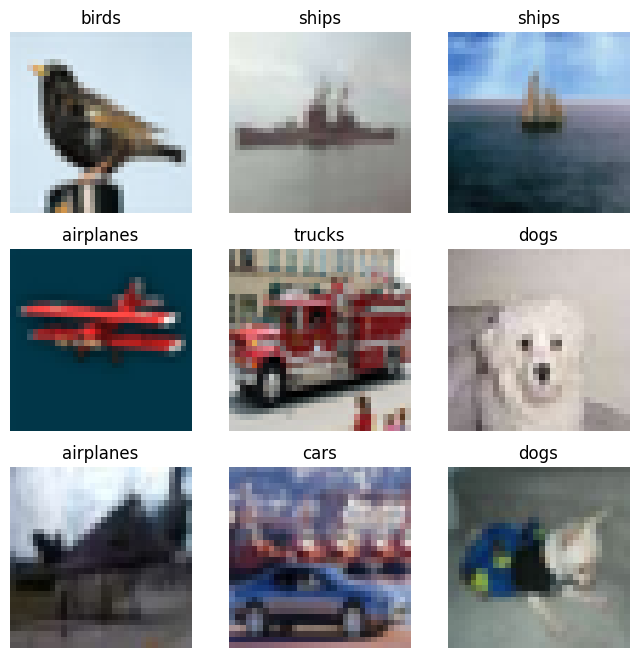

In [27]:
import matplotlib.pyplot as plt

# Опишем название классов:
labels_map = ['airplanes','cars','birds','cats','deer','dogs','frogs','horses','ships','trucks']

# Визуализируем рандомные сэмплы :
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data_cifar10), size=(1,)).item()
    img, label = training_data_cifar10[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))    # переставляем каналы [C,H,W] -> [H,W,C]
plt.show()

**Обучаем модель на CIFAR10**

In [28]:
batch_size = 64

# Инициализируем модель и data loaders:
model = NeuralNetwork(input_size=(32,32,3)).to(device)
# model = CNN(10).to(device)
train_dataloader_cifar10 = DataLoader(training_data_cifar10, batch_size=batch_size)
test_dataloader_cifar10 = DataLoader(test_data_cifar10, batch_size=batch_size)

# Задаем гипперпараметры:
epochs = 5 # для наглядности указано меньше эпох чем необходимо
batch_size = 64
lr = 1e-3

# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох (эпоха - один проход по всем данным):
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader_cifar10, model, loss_fn, optimizer)
    test(test_dataloader_cifar10, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309235  [    0/50000]
loss: 2.009279  [ 6400/50000]
loss: 1.634398  [12800/50000]
loss: 1.872438  [19200/50000]
loss: 1.950534  [25600/50000]
loss: 1.862361  [32000/50000]
loss: 1.824836  [38400/50000]
loss: 1.696025  [44800/50000]
Test Error: 
 Accuracy: 40.3%, Avg loss: 1.670548 

Epoch 2
-------------------------------
loss: 1.656413  [    0/50000]
loss: 1.614181  [ 6400/50000]
loss: 1.398736  [12800/50000]
loss: 1.763088  [19200/50000]
loss: 1.652744  [25600/50000]
loss: 1.700916  [32000/50000]
loss: 1.750591  [38400/50000]
loss: 1.589197  [44800/50000]
Test Error: 
 Accuracy: 44.3%, Avg loss: 1.569433 

Epoch 3
-------------------------------
loss: 1.602326  [    0/50000]
loss: 1.508871  [ 6400/50000]
loss: 1.336337  [12800/50000]
loss: 1.646641  [19200/50000]
loss: 1.505117  [25600/50000]
loss: 1.566315  [32000/50000]
loss: 1.644954  [38400/50000]
loss: 1.517501  [44800/50000]
Test Error: 
 Accuracy: 46.1%, Avg loss: 1.525759 

Epoc

## 8 Обучаем полносвязную сеть на CIFAR10 (grayscale, 28x28, 10 классов)

In [29]:
# Скачиваем данные для обучения:
training_data_cifar10 = datasets.CIFAR10(
    root="./dataset_cifar",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28,28)),
        transforms.ToTensor()])
)

# Скачиваем данные для теста:
test_data_cifar10 = datasets.CIFAR10(
    root="./dataset_cifar",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28,28)),
        transforms.ToTensor()])
)

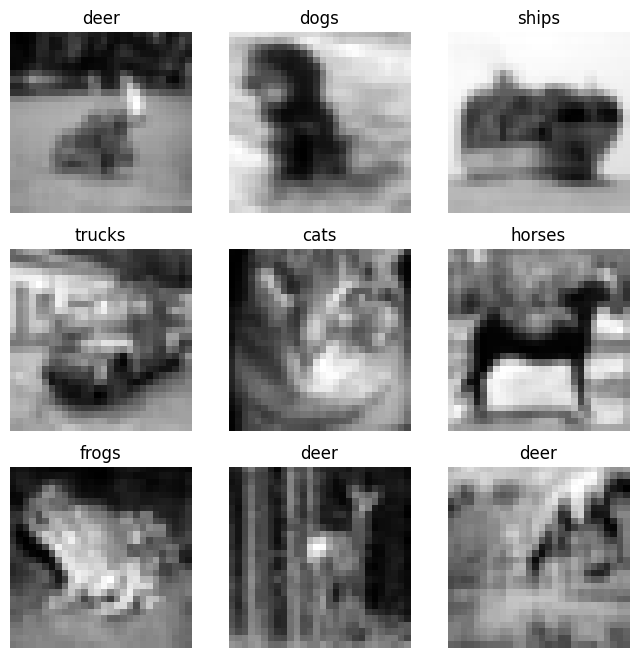

In [30]:
import matplotlib.pyplot as plt

# Опишем название классов:
labels_map = ['airplanes','cars','birds','cats','deer','dogs','frogs','horses','ships','trucks']

# Визуализируем рандомные сэмплы :
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data_cifar10), size=(1,)).item()
    img, label = training_data_cifar10[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # squeeze() - удаляем все измерения размером 1
plt.show()

In [31]:
# Инициализируем модель и data loaders:
# model = CNN(10).to(device)
model = NeuralNetwork(input_size=(28,28,1)).to(device)
train_dataloader_cifar10 = DataLoader(training_data_cifar10, batch_size=batch_size)
test_dataloader_cifar10 = DataLoader(test_data_cifar10, batch_size=batch_size)

# Задаем гипперпараметры:
epochs = 5
batch_size = 64
lr = 1e-3

# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох (эпоха - один проход по всем данным):
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader_cifar10, model, loss_fn, optimizer)
    test(test_dataloader_cifar10, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293043  [    0/50000]
loss: 2.302042  [ 6400/50000]
loss: 2.268957  [12800/50000]
loss: 2.275638  [19200/50000]
loss: 2.226986  [25600/50000]
loss: 2.232239  [32000/50000]
loss: 2.265264  [38400/50000]
loss: 2.160257  [44800/50000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 2.175444 

Epoch 2
-------------------------------
loss: 2.226964  [    0/50000]
loss: 2.179944  [ 6400/50000]
loss: 2.086504  [12800/50000]
loss: 2.244990  [19200/50000]
loss: 2.065695  [25600/50000]
loss: 2.152118  [32000/50000]
loss: 2.262793  [38400/50000]
loss: 2.060609  [44800/50000]
Test Error: 
 Accuracy: 23.2%, Avg loss: 2.103159 

Epoch 3
-------------------------------
loss: 2.142889  [    0/50000]
loss: 2.118753  [ 6400/50000]
loss: 2.002608  [12800/50000]
loss: 2.158981  [19200/50000]
loss: 2.012305  [25600/50000]
loss: 2.108402  [32000/50000]
loss: 2.191997  [38400/50000]
loss: 2.008259  [44800/50000]
Test Error: 
 Accuracy: 26.1%, Avg loss: 2.055353 

Epoc

**Обучаем модель на CIFAR10 (grayscale, 28x28)**

## 9 Transfer Learning MNIST -> CIFAR10

In [32]:
# Загружаем веса MNIST из checkpoint:
checkpoint_path = './checkpoints/mnist_checkpoint.pth'
model = NeuralNetwork()
# model = CNN(10).to(device)
model.load_state_dict(torch.load(checkpoint_path))

# Протестируем загруженную модель на MNIST:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.091091 



**Заморозим веса всех слоев кроме последнего**

In [33]:
# Отключаем градиент (кроме output слоя):
for param in model.parameters(): # Проходим по параметрам модели (каждый параметр - это каждый слой)
    param.requires_grad = False

# Пересоздаем выходной слой на 10 нейронов:
mnist_output = model.output                       # Сохраняем выходной слой MNIST
in_features = model.output.in_features
model.output = torch.nn.Linear(in_features, 10, bias=True)
# model.output = model.output.cuda()                # Перенесем на cuda
model.output = model.output
# Проверяем:
for name, param in model.named_parameters():
    print (name, param.shape, param.requires_grad)

fc1.weight torch.Size([512, 784]) False
fc1.bias torch.Size([512]) False
fc2.weight torch.Size([512, 512]) False
fc2.bias torch.Size([512]) False
output.weight torch.Size([10, 512]) True
output.bias torch.Size([10]) True


**Протестируем модель, обученную на MNIST, на CIFAR**

In [39]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU(inplace=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)

In [41]:
# Инициализируем data loaders:
train_dataloader_cifar10 = DataLoader(training_data_cifar10, batch_size=batch_size)
test_dataloader_cifar10 = DataLoader(test_data_cifar10, batch_size=batch_size)

# Протестируем модель, обученную на MNIST, на CIFAR:
test(test_dataloader_cifar10, model.to(device), loss_fn)

Test Error: 
 Accuracy: 10.1%, Avg loss: 2.408470 



**Дообучим последний слой модели на CIFAR**

In [42]:
# Задаем гипперпараметры:
epochs = 5
batch_size = 64
lr = 1e-3

# Выбираем функцию потерь и оптимайзер:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Обучаем 5 эпох (эпоха - один проход по всем данным):
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader_cifar10, model, loss_fn, optimizer)
    test(test_dataloader_cifar10, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.398180  [    0/50000]
loss: 2.191082  [ 6400/50000]
loss: 2.035359  [12800/50000]
loss: 2.173338  [19200/50000]
loss: 2.187482  [25600/50000]
loss: 2.073016  [32000/50000]
loss: 2.221336  [38400/50000]
loss: 2.014090  [44800/50000]
Test Error: 
 Accuracy: 27.2%, Avg loss: 2.047358 

Epoch 2
-------------------------------
loss: 2.080788  [    0/50000]
loss: 2.089546  [ 6400/50000]
loss: 1.903326  [12800/50000]
loss: 2.155539  [19200/50000]
loss: 2.147671  [25600/50000]
loss: 2.050531  [32000/50000]
loss: 2.156017  [38400/50000]
loss: 1.988192  [44800/50000]
Test Error: 
 Accuracy: 28.2%, Avg loss: 2.013127 

Epoch 3
-------------------------------
loss: 2.044834  [    0/50000]
loss: 2.054929  [ 6400/50000]
loss: 1.848290  [12800/50000]
loss: 2.146648  [19200/50000]
loss: 2.130210  [25600/50000]
loss: 2.038446  [32000/50000]
loss: 2.125118  [38400/50000]
loss: 1.972419  [44800/50000]
Test Error: 
 Accuracy: 28.8%, Avg loss: 1.993697 

Epoc

In [43]:
# Восстановим выходной слой MNIST:
model.output = mnist_output

# Протестируем модель еще раз на MNIST:
loss_fn = nn.CrossEntropyLoss()
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.091091 



## Теперь вы знаете как создать и обучить свою нейронную сеть!

In [44]:
# Сохраняем checkpoint:
checkpoint_path = './checkpoints/cnn_mnist_checkpoint.pth'
torch.save(cnn_model.state_dict(), checkpoint_path)

In [45]:
# Загружаем checkpoint:
checkpoint_path = './checkpoints/cnn_mnist_checkpoint.pth'
cnn_model = CNN(10)
cnn_model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>